In [4]:
import warnings

import skimage

warnings.filterwarnings("ignore")

import numpy as np

np.random.seed(0)  ## set random seed
import pandas as pd
import chardet
import os
import pickle
from collections import Counter

# For plots
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

## time and datetime
import datetime
import time

import datetime
import time

pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_seq_items', None)  # For printing a long-sequence


def null_percentage(input_data):
    df = input_data.copy()
    missing = pd.DataFrame(100 * df.isnull().sum() / len(df.index))
    missing.rename(columns={0: 'Null_Percentage'}, inplace=True)
    missing = pd.DataFrame(missing.Null_Percentage).sort_values(by='Null_Percentage', ascending=False).style.applymap(
        color_style)
    return missing


def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes = ['Non-Fraudulent', 'Fraudulent']
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)


def print_model_metrics(y_test, y_pred):
    print(" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(cp)
    plt.show()


def color_style(value):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value
    greater than 5% NaNs, and green for safer values
    and black for anything otherwise.
    """
    if value > 0:
        color = 'red'
    elif value == 0:
        color = 'green'
    else:
        color = 'black'
    return 'color: %s' % color



In [5]:
df = pd.read_csv("Dataset/creditcard.csv")

In [6]:
print(df.head())
print(df.tail())
print(df.shape)
df = df.rename(columns=lambda x: x.strip())   ##Removing whitespaces in column names (if any)
print(df.columns)
print(df.info())
print(df.describe())
print(null_percentage(df))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20 

Distribution of Classes: (0: Normal Transactions, 1: Fraud Transactions)
0    284315
1       492
Name: Class, dtype: int64

Percentage of Normal Share i.e. Non-Fraudulent Transactions(%): 99.82725143693798%
Percentage of Fraud Share i.e. Fraudulent Transactions(%): 0.1727485630620034%



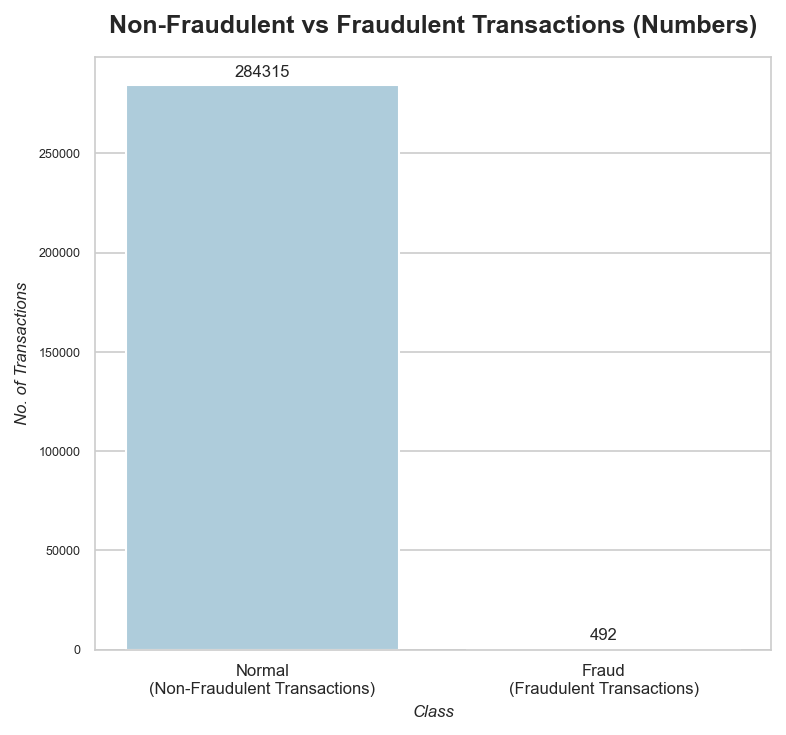

In [7]:
classes = df['Class'].value_counts()
normal_percentage = classes[0] / df['Class'].count() * 100
fraud_percentage = classes[1] / df['Class'].count() * 100
print("Distribution of Classes: (0: Normal Transactions, 1: Fraud Transactions)\n" + f"{classes}\n")
print("Percentage of Normal Share i.e. Non-Fraudulent Transactions(%): " + f"{normal_percentage}%")
print("Percentage of Fraud Share i.e. Fraudulent Transactions(%): " + f"{fraud_percentage}%\n")
class_data = [["Normal (Non-Fraudulent)", classes[0], normal_percentage], ["Fraud (Fraudulent)", classes[1], fraud_percentage]]
df_class = pd.DataFrame(class_data, columns=["Class", "num_transactions", "prcnt_transactions"])

plt.figure(figsize=(10, 5), dpi=150)
sns.set_style("whitegrid")

plt.subplot(1, 2, 1)
ax_1 = sns.barplot(data=df_class, x="Class", y="num_transactions", palette=("Paired"))
ax_1.set_xticklabels(labels=['Normal\n(Non-Fraudulent Transactions)', 'Fraud\n(Fraudulent Transactions)'], fontsize=8)
plt.title("Non-Fraudulent vs Fraudulent Transactions (Numbers)", fontsize=12, fontweight='bold', y=1.02)
plt.ylabel("No. of Transactions", fontsize=8, fontstyle='italic')
plt.xlabel("Class", fontsize=8, fontstyle='italic')
plt.yticks(fontsize=6)

for i in ax_1.patches:
    ax_1.annotate("{0:.0f}".format(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()), ha='center' \
                  , va='top', xytext=(0, 10), textcoords='offset points', rotation=0, fontsize=8)
plt.tight_layout()
plt.autoscale()
plt.show()

<Figure size 1200x1400 with 0 Axes>

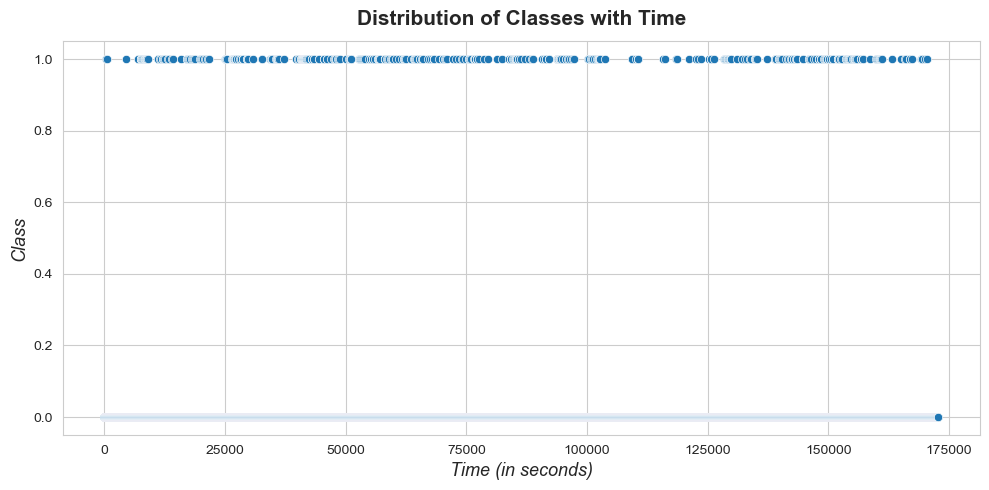

<Figure size 1200x1400 with 0 Axes>

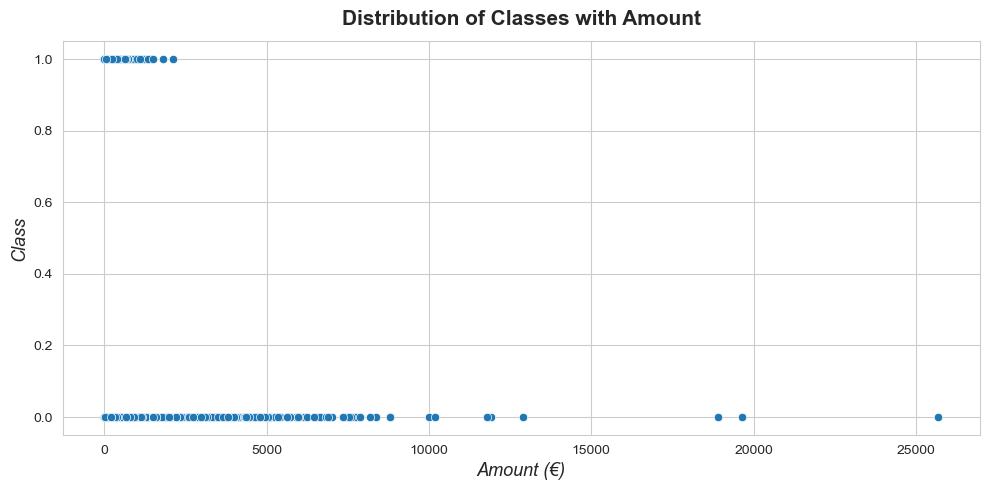

Maximum fraud transaction amount: €2125.87


In [8]:
def scatter_plot(fig_size, title, my_data, x, y, x_unit):
    fig = plt.figure(figsize=fig_size)
    cmap = sns.color_palette('Set1')

    df = my_data.copy()
    plt.figure(figsize=(10, 5), dpi=100)
    sns.set_style("whitegrid")
    sns.scatterplot(x=x, y=y, data=df)
    plt.title((f"{title}"), fontweight='bold', fontsize=15, y=1.02)
    plt.xlabel(x + f" {x_unit}", fontsize=13, fontstyle='italic')
    plt.ylabel(y, fontsize=13, fontstyle='italic')

    plt.grid(True)
    plt.autoscale()
    plt.tight_layout()
    plt.show()


scatter_plot(fig_size=(12, 14), title="Distribution of Classes with Time", my_data=df, x="Time",
             x_unit="(in seconds)", y="Class")
scatter_plot(fig_size=(12, 14), title="Distribution of Classes with Amount", my_data=df, x="Amount", x_unit="(€)",
             y="Class")
max_trnsctn_fraud = df[df.Class == 1]["Amount"].max()
print(f"Maximum fraud transaction amount: €{max_trnsctn_fraud}")


Statistical summary of 'Amount' feature (Normal Transactions):

 count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
10%           1.000000
25%           5.650000
50%          22.000000
75%          77.050000
90%         202.724000
95%         364.409000
99%        1016.966400
100%      25691.160000
max       25691.160000
Name: Amount, dtype: float64

Statistical summary of 'Amount' feature (Fraud Transactions):

 count     492.000000
mean      122.211321
std       256.683288
min         0.000000
10%         0.760000
25%         1.000000
50%         9.250000
75%       105.890000
90%       346.746000
95%       640.905000
99%      1357.427900
100%     2125.870000
max      2125.870000
Name: Amount, dtype: float64


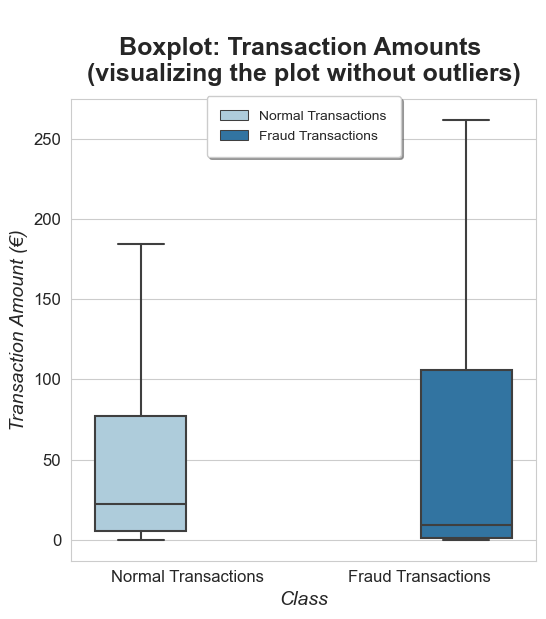

In [9]:
summary_class_0 = df[df.Class == 0].Amount.describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])
summary_class_1 = df[df.Class == 1].Amount.describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])
print(f"\nStatistical summary of 'Amount' feature (Normal Transactions):\n\n", summary_class_0)
print(f"\nStatistical summary of 'Amount' feature (Fraud Transactions):\n\n", summary_class_1)

## Visualising the statistics of transaction amounts
plt.figure(figsize=(6, 6), dpi=100)
sns.set_style("whitegrid")

## Note: Set (showflier=False) to eliminate the effect of outliers in the transaction amounts
ax_31= sns.boxplot(data=df, y="Amount", x="Class", hue="Class",showfliers=False, palette=("Paired"))
ax_31.set_xticklabels(labels=['Normal Transactions','Fraud Transactions'], fontsize=12)
plt.title(f"\nBoxplot: Transaction Amounts \n(visualizing the plot without outliers)", fontsize=18, fontweight='bold', y=1.02)
plt.ylabel("Transaction Amount (€)", fontsize=14, fontstyle='italic')
plt.xlabel("Class", fontsize=14, fontstyle='italic')
plt.yticks(fontsize=12)

#legend
L31= ax_31.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
L31.get_texts()[0].set_text('Normal Transactions')
L31.get_texts()[1].set_text('Fraud Transactions')

plt.show()

### Analyzing the Time variable before we come to any conclusion.

In [10]:
df.Time.head()
df.Time.tail()

284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, dtype: float64

In [11]:
## Using pandas 'to_timedelta' to convert pandas Series from a recognized timedelta format / value into a Timedelta type
Time_Delta= pd.to_timedelta(df.Time, unit='s')
Time_Delta.head()
Time_Delta.tail()

284802   1 days 23:59:46
284803   1 days 23:59:47
284804   1 days 23:59:48
284805   1 days 23:59:48
284806   1 days 23:59:52
Name: Time, dtype: timedelta64[ns]

In [12]:
df['Time_Days']= (Time_Delta.dt.components.days).astype(int) ## Number of days
df['Time_Hours']= (Time_Delta.dt.components.hours).astype(int) ## Number of hours
df['Time_Minutes']= (Time_Delta.dt.components.minutes).astype(int) ## Number of minutes

df[['Time', 'Time_Days', 'Time_Hours', 'Time_Minutes']].tail()  ##Checking the tail for verifying successful opera

Time  Time_Days  Time_Hours  Time_Minutes
284802  172786.0          1          23            59
284803  172787.0          1          23            59
284804  172788.0          1          23            59
284805  172788.0          1          23            59
284806  172792.0          1          23            59

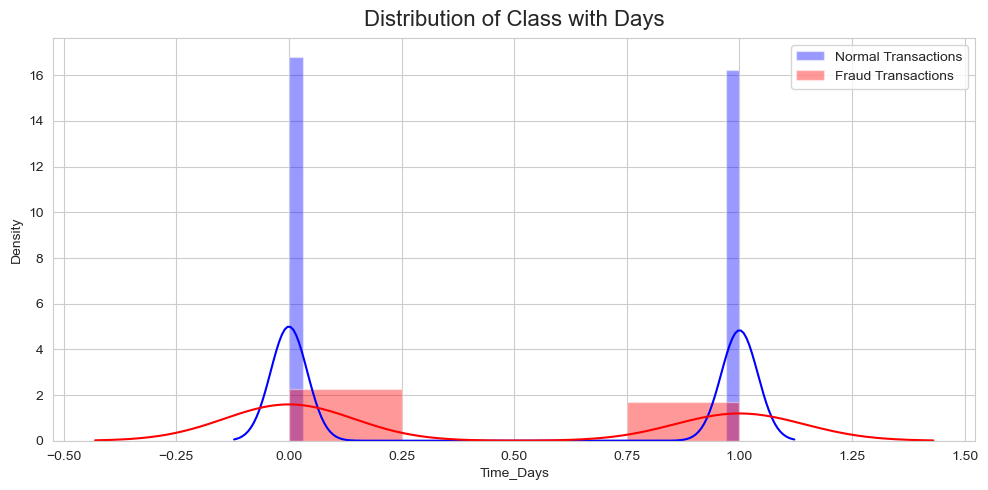

In [13]:
## Analyzing distribution of classes with days

plt.figure(figsize=(10,5), dpi=100)

sns.distplot(df[df.Class == 0]["Time_Days"], label= "Normal Transactions", color='blue')
sns.distplot(df[df.Class == 1]["Time_Days"], label= "Fraud Transactions", color= 'red')

plt.title('Distribution of Class with Days', fontsize=16, y=1.01)
plt.legend()
plt.tight_layout()
plt.show()

Observation:
(i) It is obvious that the density of non-fraudulent (normal) transactions is very high in comparison to the fradulent transactions.
(ii) Time_Days feature doesn't offer much insights as we only have the records for day 0 and day 1 respectively.

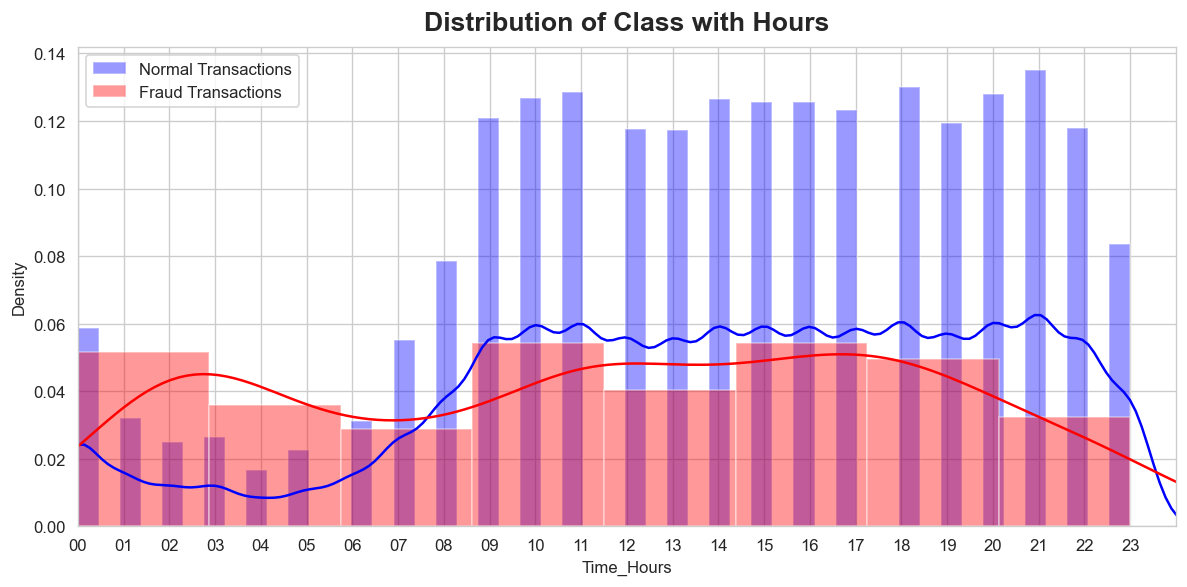

In [14]:
## Analyzing distribution of classes with hours

fig= plt.figure(figsize=(10,5), dpi=120)
ax_4= fig.add_subplot(1,1,1)
sns.set_style("whitegrid")

ax_4= sns.distplot(df[df.Class == 0]["Time_Hours"], label= "Normal Transactions", color='blue')  # Distplot for normal transactions
ax_4= sns.distplot(df[df.Class == 1]["Time_Hours"], label= "Fraud Transactions", color= 'red')  #Distplot for fraud transactions

ax_4.set_title('Distribution of Class with Hours', fontsize=16, fontweight='bold', pad=10)
plt.xlim(0,24)                          ## Limitng the x-axis to number of hours in a day
ax_4.set_xticks(np.arange(0,24))

## List Labels
list_a= ['0'+str(i) for i in list(np.arange(0,10))]
list_b= [str(i) for i in list(np.arange(10,24))]
list_a.extend(list_b)
list_hours= [str(j) for j in list_a]
ax_4.set_xticklabels(list_hours)

plt.legend()
plt.tight_layout()
plt.show()

In [15]:
num_fraud_hrs= df[df.Class==1]['Time_Hours'].value_counts()
num_fraud_hrs

2     57
11    53
18    33
17    29
15    26
4     23
7     23
14    23
16    22
23    21
19    19
20    18
13    17
12    17
3     17
9     16
21    16
5     11
1     10
8      9
6      9
22     9
10     8
0      6
Name: Time_Hours, dtype: int64

Observations:
(i) No distinct fixed pattern (w.r.t. fraud transactions) can be seen from the hours.
(ii) From the distribution plot of normal transactions we can infer that most number of normal transactions took place from 08 hours till midnight (00 hours).
(iii) Normal transactions are less in number during night time (from midnight (i.e. 00 hours) till 08 hours).
(iv) Most number of Fraud Transactions took place at 02 (no. of txns= 57), 11 (no. of txns= 53) and 18 (no. of txns= 33) hours respectively. No Fraud Transactions occurred early morning at 06 hours.

As this is not a time-series problem and no further insights can be derived from the 'Time' feature and associated derived time features, we can drop all the time variables-> "Time","Time_Days", "Time_Hours" and "Time_Minutes" feature columns.

In [16]:
# Drop unnecessary columns
drop_columns= ["Time","Time_Days","Time_Hours", "Time_Minutes"]  # (all time variables - original and derived ones)
df.drop(drop_columns, axis=1, inplace= True)
df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

# Correlational Analysis

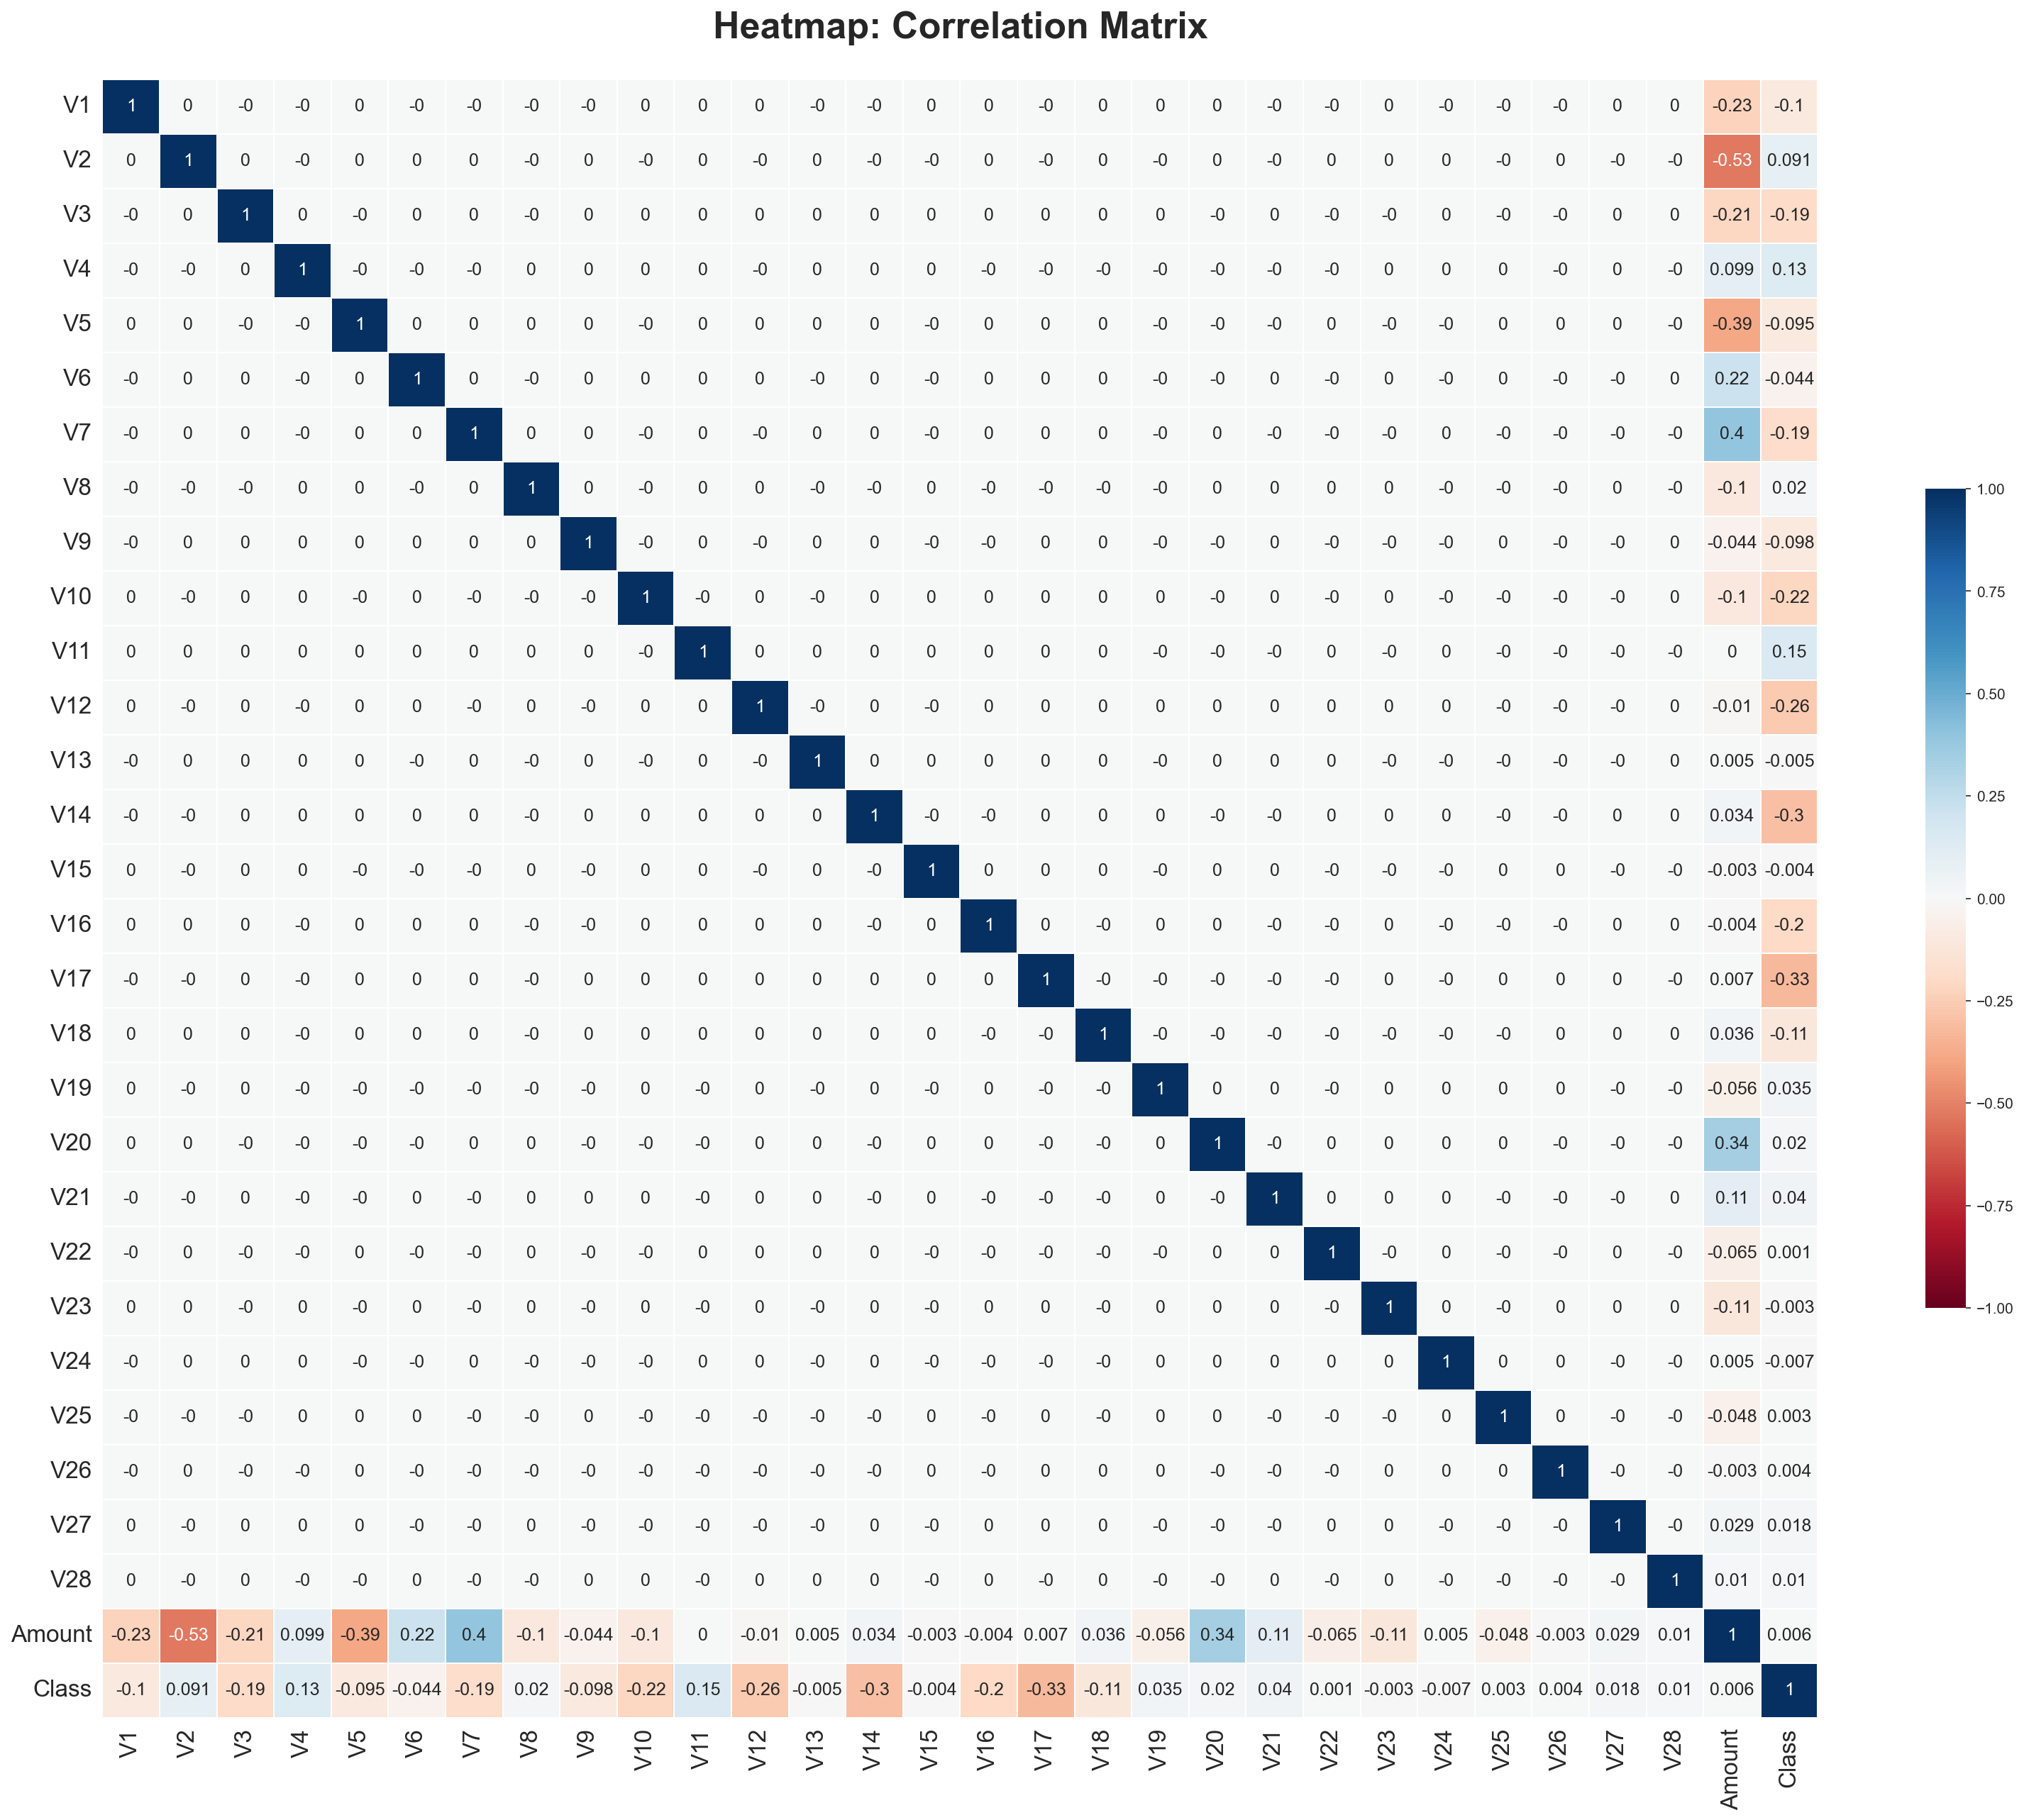

In [17]:
#Plotting a heatmap to understand the correlation between the independent variables
correlational_matrix = df.corr()
correlational_matrix_round= round(correlational_matrix, 3)
f, ax_corr = plt.subplots(figsize=(26,20), dpi=150)
ax_corr = sns.heatmap(correlational_matrix_round,annot=True,cmap="RdBu", cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0, \
                      linewidths=0.01, annot_kws={"size":12})
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=0)
plt.title("Heatmap: Correlation Matrix", y=1.02, fontsize=25, fontweight='bold')
plt.show()

In [18]:
## Analyzing Top 10 correlated PCA components with 'Class'
correlational_matrix_class= pd.DataFrame(correlational_matrix['Class'])
correlational_matrix_class["absolute_corr_val"]= correlational_matrix_class.apply(lambda x: abs(x))

## Sorting in descending order (of absolute values of correlation coefficients)
correlational_matrix_top10_class= correlational_matrix_class.sort_values(by="absolute_corr_val", ascending=False)[1:11]
print(f"Top 10 feature variables related with Class:\n {list(correlational_matrix_top10_class.index)}")

## Top 10 correlated variables with class (except Class variable)
top10_df= pd.DataFrame({"Rank": np.arange(1,11), "Top10_Feature_Variables": correlational_matrix_top10_class.index, \
                        "Correlation_with_Class": correlational_matrix_top10_class.Class})
top10_df.set_index("Rank", inplace=True)
top10_df

Top 10 feature variables related with Class:
 ['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18']


Top10_Feature_Variables  Correlation_with_Class
Rank                                                
1                        V17               -0.326481
2                        V14               -0.302544
3                        V12               -0.260593
4                        V10               -0.216883
5                        V16               -0.196539
6                         V3               -0.192961
7                         V7               -0.187257
8                        V11                0.154876
9                         V4                0.133447
10                       V18               -0.111485

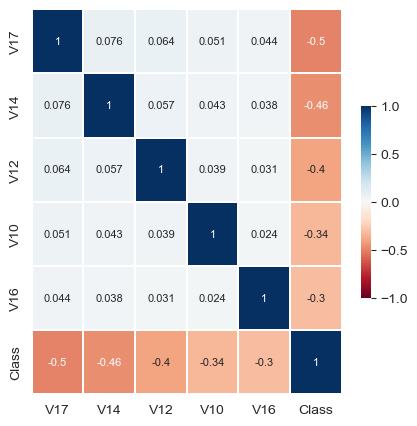

In [19]:
## Visualizing correlation of Top5 feature variables with 'Class'
top5_features= list(correlational_matrix_top10_class.index)[0:5]
top5_features.append('Class')
correlational_matrix_top= correlational_matrix_round[top5_features].corr()
plt.figure(figsize=(5,5),dpi=100)
sns.heatmap(correlational_matrix_top, cmap= "RdBu", annot= True,cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0, linewidths=0.01, annot_kws={"size":8})
plt.show()

### Understanding the Distribution of Input Feature Variables

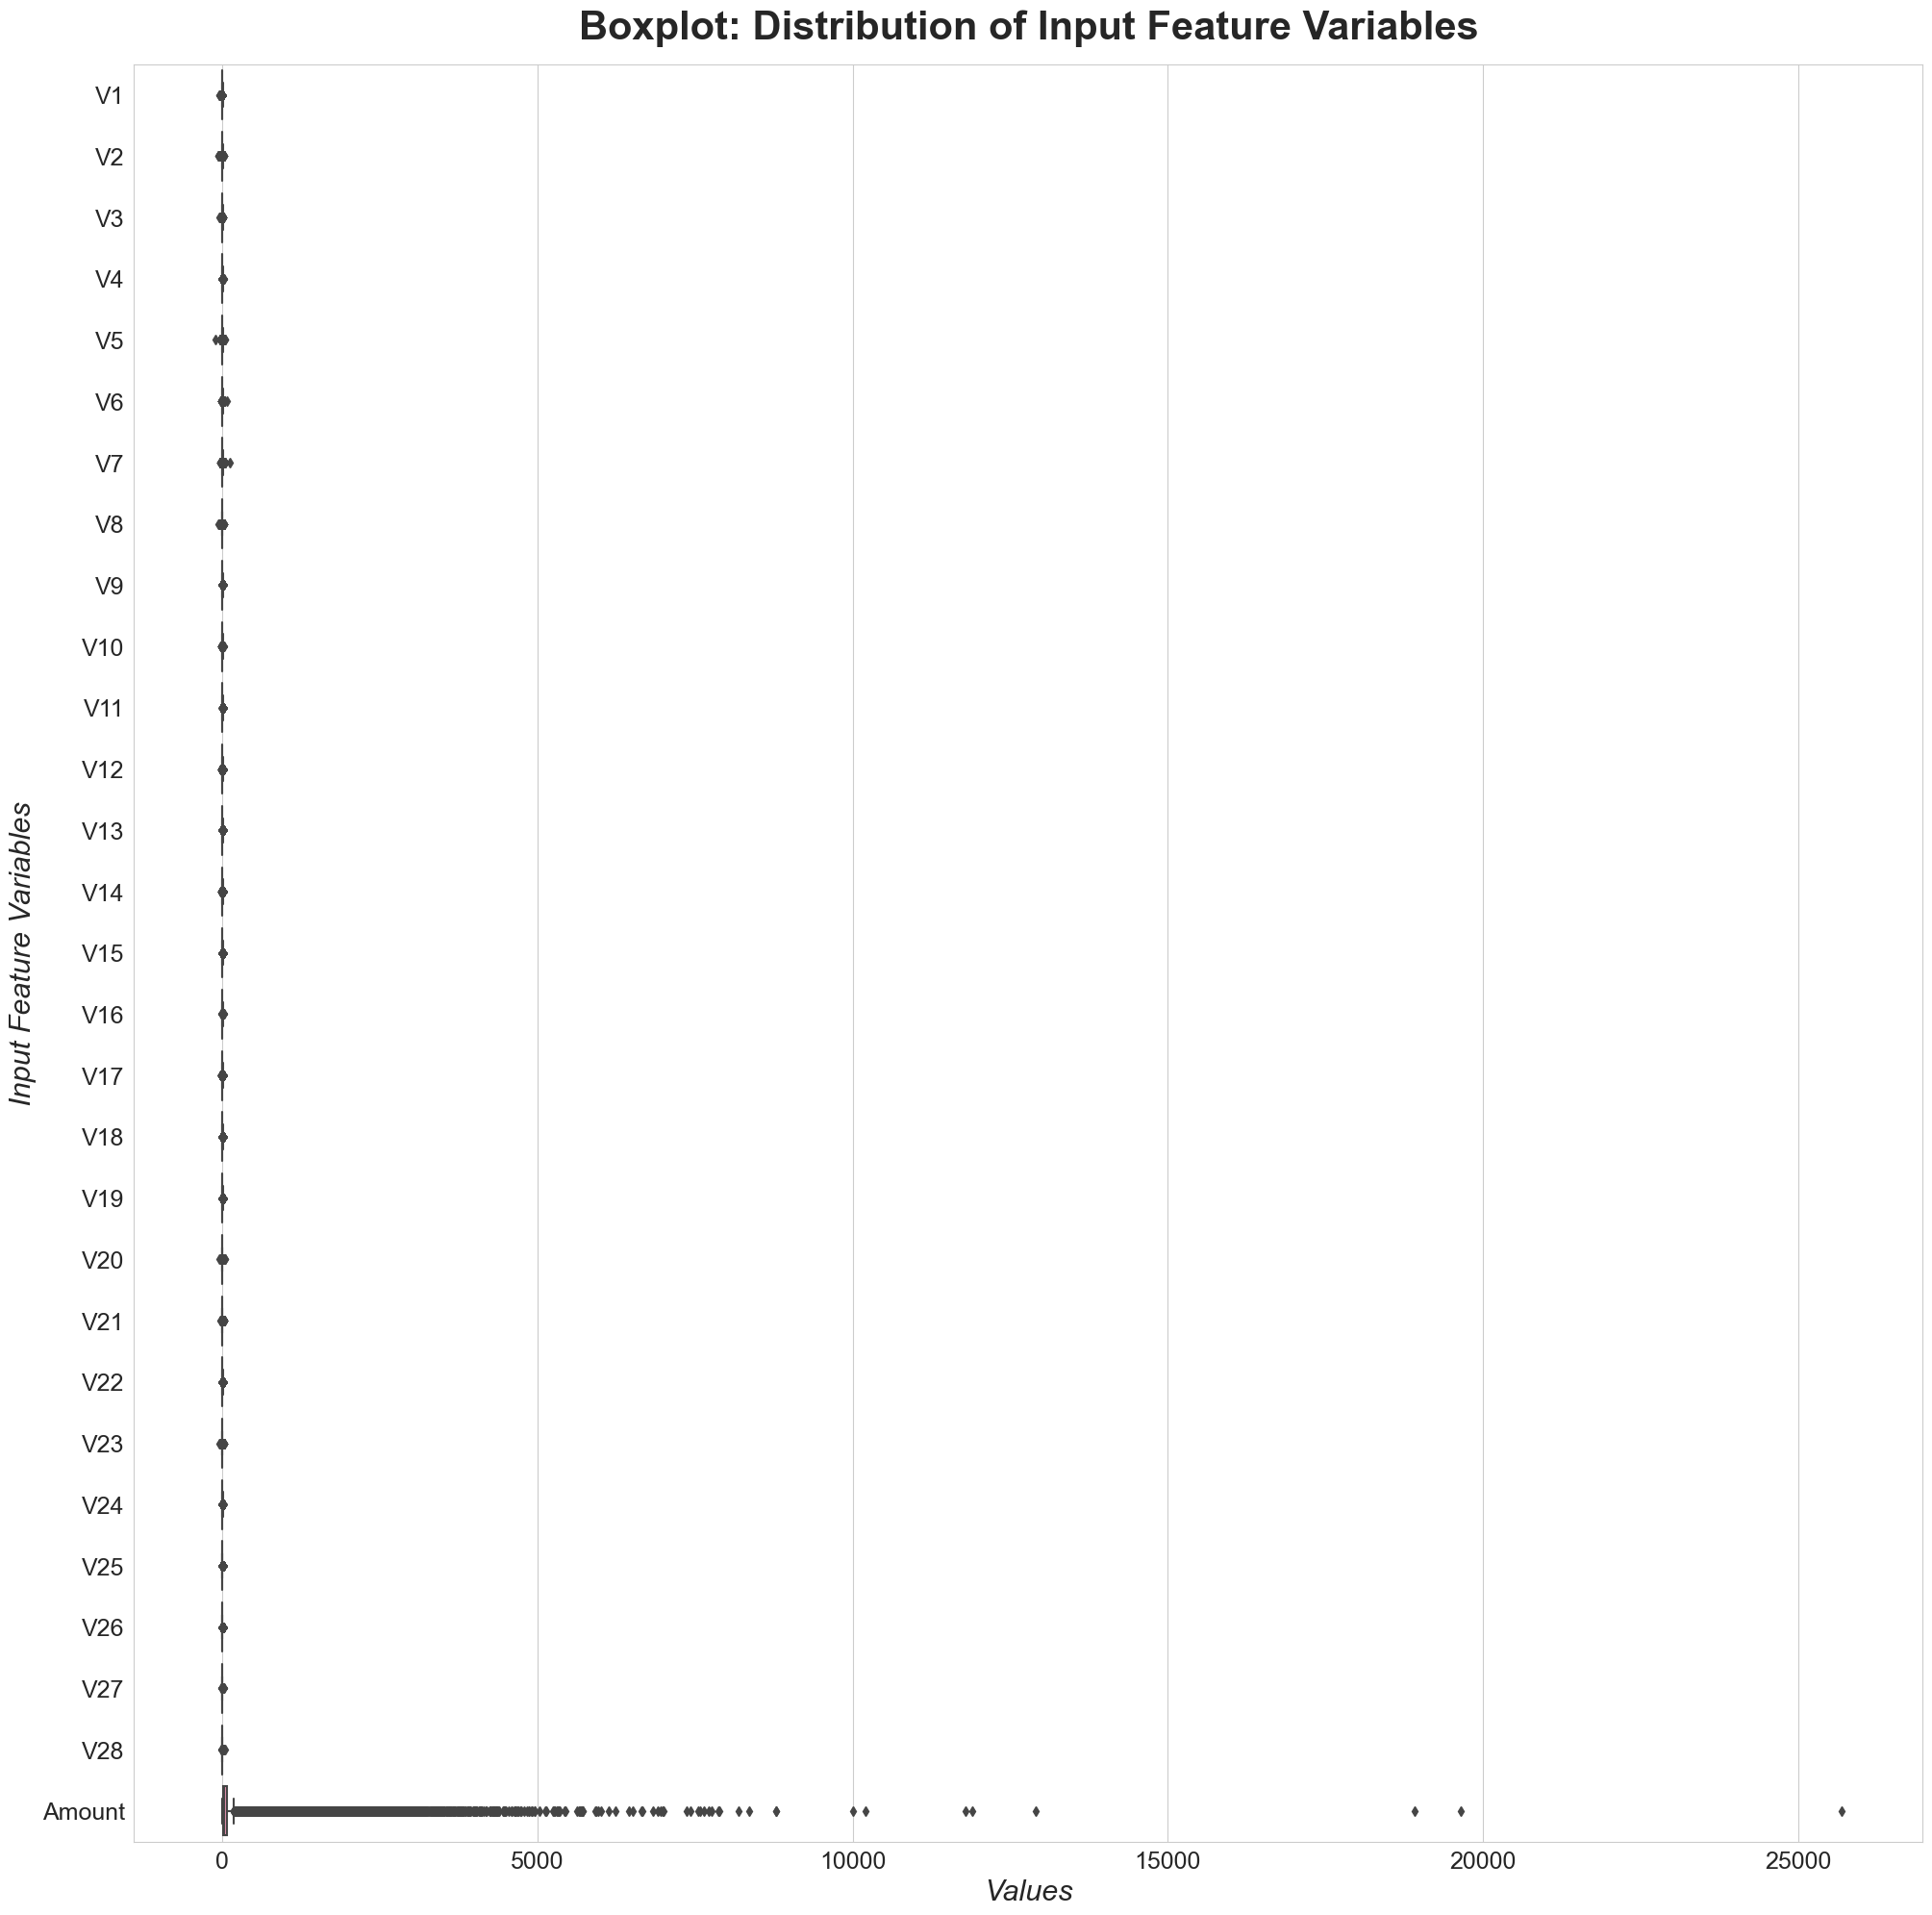

In [20]:
# Boxplot to understand the distribution of numerical attributes :
numeric_feature_variables= df.select_dtypes(include=['float64','int64', 'int32'])

## Exluding dependent variables "Class" from the list
numeric_feature_variables= [i for i in numeric_feature_variables if i!="Class"]

plt.figure(figsize=(24,24))
sns.boxplot(data= df[numeric_feature_variables], orient= "h")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Boxplot: Distribution of Input Feature Variables", y=1.01, fontsize=30, fontweight='bold')
plt.ylabel("Input Feature Variables", fontstyle='italic', fontsize=22)
plt.xlabel("Values", fontstyle='italic', fontsize=22)
plt.show()

# Splitting the data into train & test data

In [21]:
y= df['Class']        #Class variable
X= df.drop("Class", axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.30, stratify= y)

In [23]:
print("In y dataset:", Counter(y))
print("In y_train set:", Counter(y_train))
print("In y_test set:", Counter(y_test))

In y dataset: Counter({0: 284315, 1: 492})
In y_train set: Counter({0: 199020, 1: 344})
In y_test set: Counter({0: 85295, 1: 148})


### Visualisation of V1 to V12 -> plotting distribution of variables
- checking skeness in train data

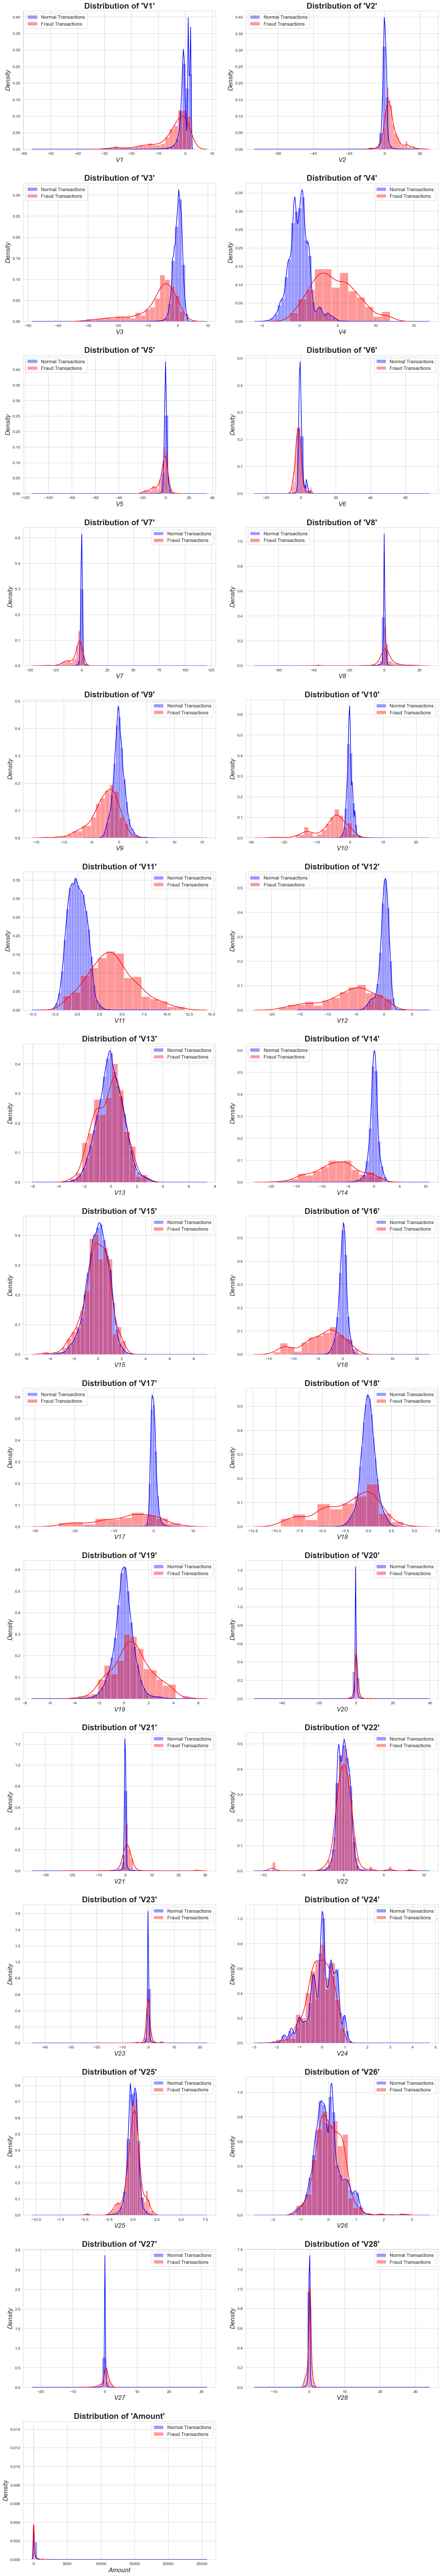

In [24]:
input= list(X.columns)       # list of input feature variables (analyzing entire dataset)

f1, ax_skew1 = plt.subplots(15,2, figsize=(16,90))
f1.delaxes(ax_skew1[14,1])    ## Passing indices of axes--This line will delete the last axis (used for odd-subplots)

for index, feature in enumerate(input):
    plt.subplot(15,2,index+1)
    sns.distplot(X_train[feature][df.Class == 0], label= "Normal Transactions", color='blue')       ## Distplot for feature density in Normal Transactions
    sns.distplot(X_train[feature][df.Class == 1], label= "Fraud Transactions", color= 'red')  ## Distplot for feature density in Fraud Transactions
    plt.title(f"Distribution of '{feature}'", fontsize= 20, fontweight='bold')
    plt.xlabel(feature, fontsize=16, fontstyle= 'italic')
    plt.ylabel("Density", fontsize=16, fontstyle= 'italic')
    plt.tight_layout(pad=3.0)   ##Increase spacing between subplots
    plt.legend(fontsize= 12)
plt.show()

## Skewness Mitigation
- Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train data & transform the test data

In [25]:
## For X dataset (train and test)
pt = PowerTransformer(copy=False)
X_train_pt= pt.fit_transform(X_train)
X_test_pt = pt.transform(X_test)

In [26]:
## Create a dataframes for PowerTransformed 'X_train' and 'X_test' respectively (to be used later)
df_X_train_pt= pd.DataFrame(data= X_train_pt, columns= list(X.columns))
df_X_test_pt= pd.DataFrame(data= X_test_pt, columns= list(X.columns))

Visualisation of V1 to V12 -> plotting distribution of variables
 - {train data} after transformer

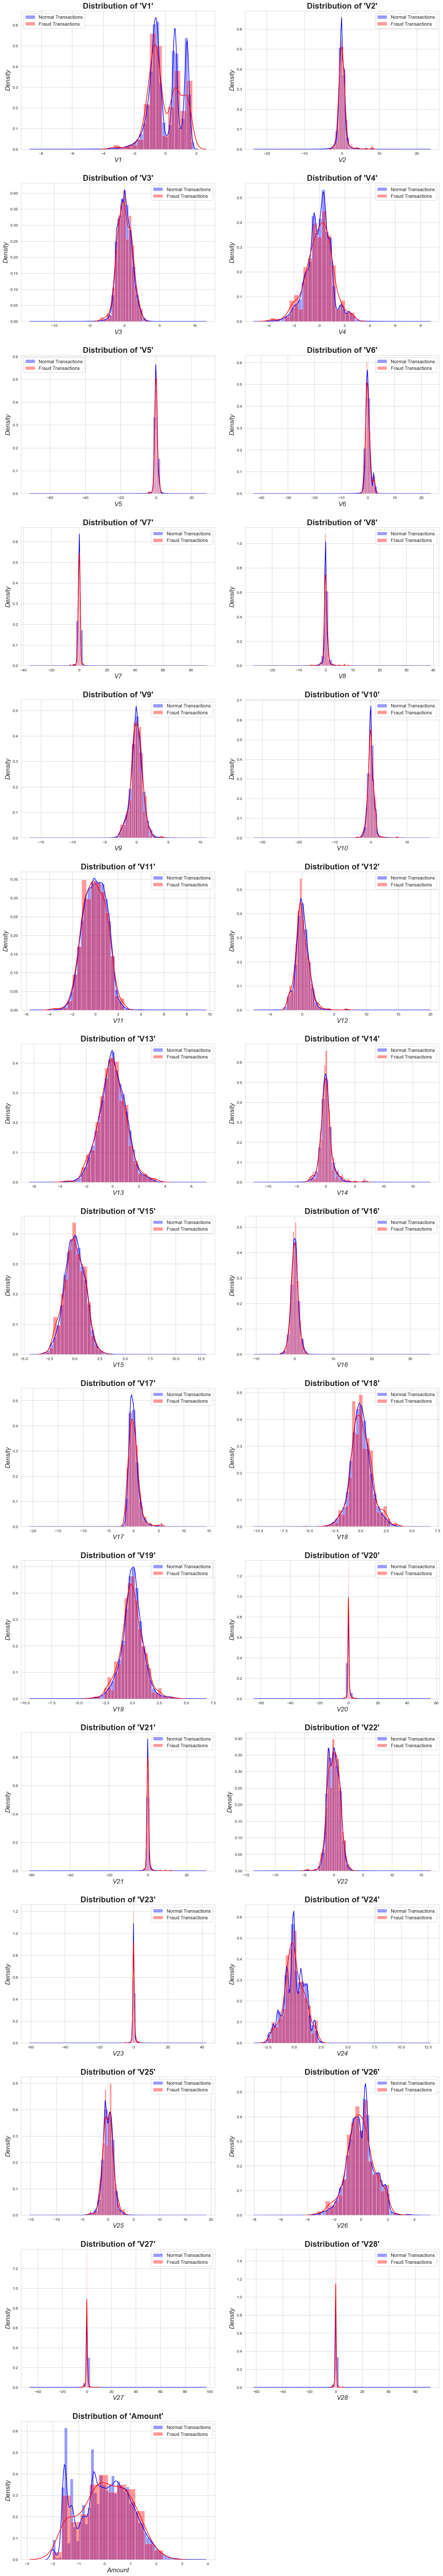

In [27]:
input= list(X.columns)       # list of input feature variables (analyzing entire dataset)

f1, ax_skew1 = plt.subplots(15,2, figsize=(16,90))
f1.delaxes(ax_skew1[14,1])

for index, feature in enumerate(input):
    plt.subplot(15,2,index+1)
    sns.distplot(df_X_train_pt[feature][df.Class == 0], label= "Normal Transactions", color='blue')
    sns.distplot(df_X_train_pt[feature][df.Class == 1], label= "Fraud Transactions", color= 'red')
    plt.title(f"Distribution of '{feature}'", fontsize= 20, fontweight='bold')
    plt.xlabel(feature, fontsize=16, fontstyle= 'italic')
    plt.ylabel("Density", fontsize=16, fontstyle= 'italic')
    plt.tight_layout(pad=3.0)   ##Increase spacing between subplots
    plt.legend(fontsize= 12)
plt.show()

Visualisation of V1 to V12 -> plotting distribution of variables
 - {test data} after transformer

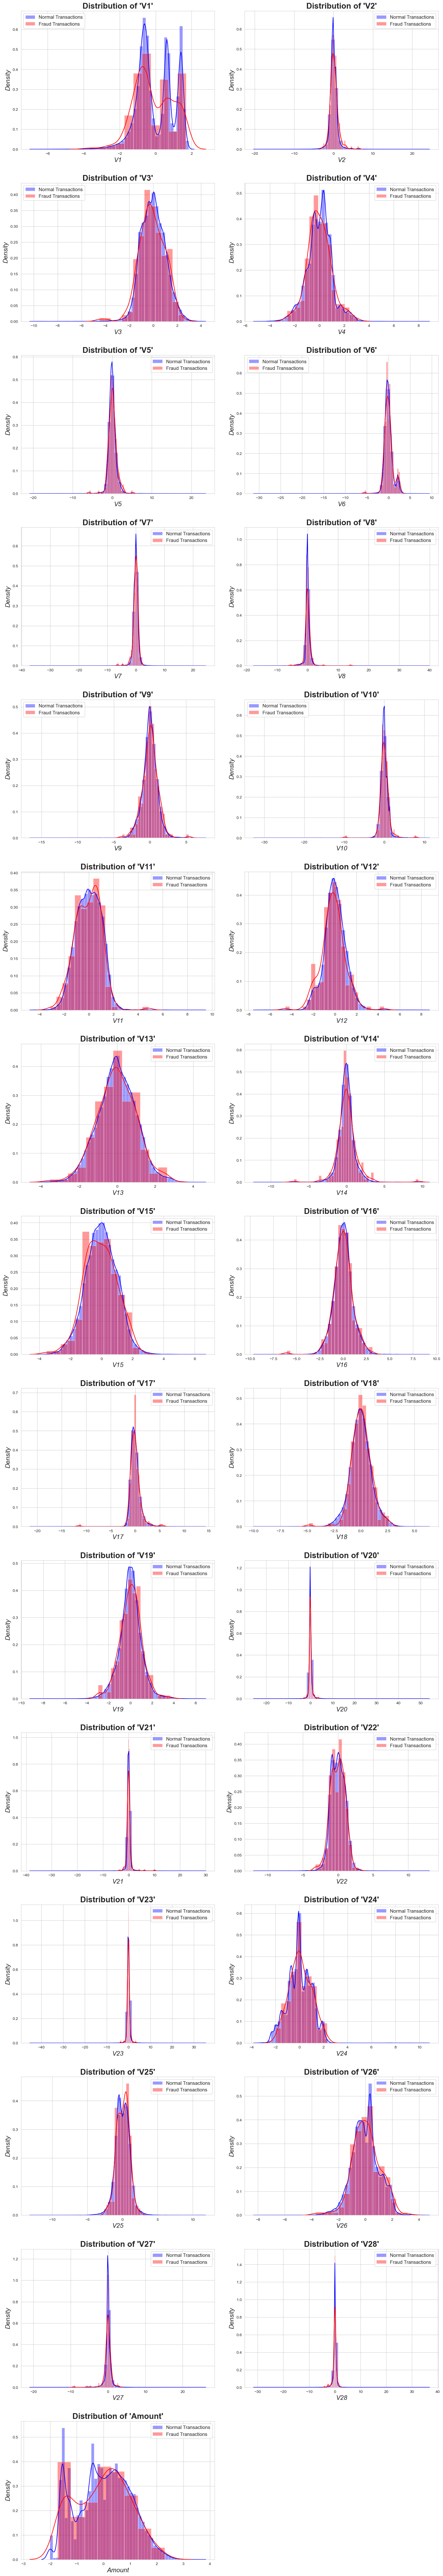

In [28]:
input= list(X.columns)       # list of input feature variables (analyzing entire dataset)

f1, ax_skew1 = plt.subplots(15,2, figsize=(16,90))
f1.delaxes(ax_skew1[14,1])    ## Passing indices of axes--This line will delete the last axis (used for odd-subplots)

for index, feature in enumerate(input):
    plt.subplot(15,2,index+1)
    sns.distplot(df_X_test_pt[feature][df.Class == 0], label= "Normal Transactions", color='blue')  ## Distplot for feature density in Normal Transactions
    sns.distplot(df_X_test_pt[feature][df.Class == 1], label= "Fraud Transactions", color= 'red')  ## Distplot for feature density in Fraud Transactions
    plt.title(f"Distribution of '{feature}'", fontsize= 20, fontweight='bold')
    plt.xlabel(feature, fontsize=16, fontstyle= 'italic')
    plt.ylabel("Density", fontsize=16, fontstyle= 'italic')
    plt.tight_layout(pad=3.0)   ##Increase spacing between subplots
    plt.legend(fontsize= 12)
plt.show()

# Model training
- training on imbalanced dataset (to analyse result)

In [29]:
#Create a pandas dataframe to store model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score'])

### functions for above operations

In [30]:
def ROC_AUC_cv(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()

def Cross_Validation_Res(random_cv,data_handling_technique, model_name):
    print(f"Data Handling Technique: {data_handling_technique}\nModel Name: {model_name}")
    print("Evaluation results from cross-validation and optimal hyperparameters\n")
    # Best Model and optimal hyperparameters
    print("Best Estimator:\n", random_cv.best_estimator_._final_estimator)
    print("Best ROC_AUC (mean cross-validated score):", random_cv.best_score_)
    print("Best (Optimal) Parameters:", random_cv.best_params_)

def Pred_Eval_Metric(random_cv, X_test, y_test, data_handling_technique, model_name):
    print("\nPrediction and Evaluation results: On Actual TEST SET")
    y_pred= random_cv.predict(X_test)                                             # Find predicted values
    y_pred_probs = random_cv.predict_proba(X_test)[:,1]                           # Find predicted probabilities
    precision = metrics.precision_score(y_pred=y_pred, y_true=y_test)           # Precision and Recall Scores
    recall= metrics.recall_score(y_pred=y_pred, y_true=y_test)
    f1_score= metrics.f1_score(y_pred=y_pred, y_true=y_test)                    # f1_score
    test_roc_auc = metrics.roc_auc_score(y_score= y_pred_probs, y_true=y_test)  # Test ROC_AUC
    print(f"\nTest ROC_AUC: {test_roc_auc}")
    test_accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)        # test accuracy
    print(f"Test Accuracy: {test_accuracy}\n")
    print("Confusion Matrix")                                                   # print confusion matrix
    print_model_metrics(y_test, y_pred)
    print("Classification Report")                                              # Print classification report
    print(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs)              # fpr, tpr and threshold
    threshold= thresholds[np.argmax(tpr-fpr)]                                   # Find the optimal threshold value
    print("Optimal Threshold:", threshold)
    ROC_AUC_cv(fpr, tpr, test_roc_auc)                                  # Plot ROC_AUC curve for test dataset (using defined function)
    ## Store results
    res_store_df= pd.DataFrame({'Data Handling Technique': [data_handling_technique],'Model': [model_name],
                                    'ROC_AUC_cv': [random_cv.best_score_],'ROC_AUC_test': [test_roc_auc],'Threshold': [threshold],
                                    'Precision': [precision],'Recall': [recall],'F1 score':[f1_score]})
    return res_store_df

### Defining functions to build the XGBoost ML models with Stratified_K_Fold_cv:

In [31]:
skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [ ]:

from numpy import interp
from sklearn.metrics import roc_curve

learning_rate = [0.05, 0.1]

mean_roc_auc_scores_val = []
mean_precision_scores_val = []
mean_recall_scores_val = []
mean_f1_scores_val = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax2 = plt.subplots(figsize=(14, 7))
for l in learning_rate:
    print("Learning Rate =", learning_rate)
    cv_scores_val = []
    precision_val = []
    recall_val = []
    f1_val = []
    fprs_val = []
    tprs_val = []

    # Perform cross-validation
    for train_index, val_index in skf.split(X_train_pt, y_train):
        start_time = time.time()
        print("Train:", train_index, "val:", val_index)
        X_train_cv, X_val_cv = X_train_pt[train_index], X_train_pt[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

        xgb_classifier = xgb.XGBClassifier(learning_rate = l, n_estimators=100, max_depth=3, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', reg_alpha=0.005, reg_lambda=1, random_state=42)
        xgb_classifier.fit(X_train_cv, y_train_cv)

        y_val_pred = xgb_classifier.predict_proba(X_val_cv)
        val_score = roc_auc_score(y_true=y_val_cv, y_score=y_val_pred[:, 1])
        cv_scores_val.append(val_score)

        y_val_pred_binary = (y_val_pred[:, 1] >= 0.5).astype(int)

        precision_val.append(precision_score(y_val_cv, y_val_pred_binary))
        recall_val.append(recall_score(y_val_cv, y_val_pred_binary))
        f1_val.append(f1_score(y_val_cv, y_val_pred_binary))

        fpr_val, tpr_val, _ = roc_curve(y_true=y_val_cv, y_score=y_val_pred[:, 1])
        tprs_val.append(interp(mean_fpr, fpr_val, tpr_val))
        tprs_val[-1][0] = 0.0
        fprs_val.append(fpr_val)
        elapsed_time = time.time() - start_time
        print("Time elapsed:", elapsed_time, "seconds")

    mean_roc_auc_val = np.mean(cv_scores_val)
    mean_roc_auc_scores_val.append(mean_roc_auc_val)

    mean_precision_val = np.mean(precision_val)
    mean_precision_scores_val.append(mean_precision_val)

    mean_recall_val = np.mean(recall_val)
    mean_recall_scores_val .append(mean_recall_val)

    mean_f1_val = np.mean(f1_val)
    mean_f1_scores_val.append(mean_f1_val)

    print("ROC-AUC Score for val data =", mean_roc_auc_val)
    print("Mean precision val score:", mean_precision_val)
    print("Mean recall val score:", mean_recall_val)
    print("Mean f1 val score:", mean_f1_val)

    ax2.plot(mean_fpr, np.mean(tprs_val, axis=0), label='Learning Rate = ' + str(l) + ', val ROC-AUC = ' + str(round(mean_roc_auc_val, 4)))


ax2.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random', alpha=0.5)

# Set labels and title for ROC curves
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - val Data')
ax2.legend(loc="lower right")
ax2.grid(True)  # Add grid to the plot

# Show the plot
plt.show()

with plt.style.context('dark_background'):
    plt.figure(figsize=(8, 12), facecolor='m')

    # Plot ROC-AUC scores vs C
    plt.plot(learning_rate, mean_roc_auc_scores_val, 'co-')
    plt.xlabel('learning_rate')
    plt.ylabel('ROC-AUC Score')
    plt.title('ROC-AUC Score vs. learning_rate_values for XGBoost')
    plt.legend(['val result'], loc='upper right')
    plt.grid()

    plt.show()

print("Mean ROC-AUC scores for val data for all values of Learning Rate: \n", mean_roc_auc_scores_val)

# Find the index of maximum mean ROC-AUC score for val data
best_index = np.argmax(mean_roc_auc_scores_val)
best_learning_rate = learning_rate[best_index]
best_mean_roc_auc = mean_roc_auc_scores_val[best_index]

print("Best Learning Rate :", best_learning_rate)
print("Best Mean ROC-AUC score for val data:", best_mean_roc_auc)
print("Mean precision val score for best C", mean_precision_scores_val[best_index])
print("Mean recall val score for best C", mean_recall_scores_val[best_index])
print("Mean f1 val score for best C", mean_f1_scores_val[best_index])

In [ ]:
from sklearn.model_selection import GridSearchCV


def XGBoost_cv(X_train, y_train, X_test, y_test, sampling_technique, data_handling_technique, modelName, df_res):
    start_time = time.time()
    skf = StratifiedKFold(n_splits= 3, random_state=0, shuffle=True)
    if (sampling_technique == None):
        xgb_pipe = make_pipeline(xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc'))
    else:
        xgb_pipe = make_pipeline(sampling_technique, XGBClassifier(objective='binary:logistic', eval_metric='auc'))

    Param_distribution_xgb = {
        'learning_rate': [0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.7, 0.9],
    }
    grid_serch_cv = GridSearchCV(
        xgb_pipe,
        param_grid=Param_distribution_xgb,
        scoring='roc_auc',
        cv=skf,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    grid_serch_cv.fit(X_train, y_train)
    Cross_Validation_Res(grid_serch_cv, data_handling_technique, modelName)

    opt_random_serch_cv = grid_serch_cv.best_estimator_._final_estimator

    df_res_store = Pred_Eval_Metric(grid_serch_cv, X_test, y_test, data_handling_technique, modelName)
    df_res= df_res.append(df_res_store, ignore_index=True)
    end_time = time.time()
    print(f"\nTime required to train the model: {round((end_time - start_time) / 60)} minutes")
    return df_res, opt_random_serch_cv


In [ ]:
df_res, xgb_imbalance_data = XGBoost_cv(df_X_train_pt, y_train, df_X_test_pt, y_test, None,"Power Transformer (Imbalanced Dataset)", "XGBoost with StratifiedKFoldCV", results_df)

In [ ]:
def Precesion_Recall_AUC_Calculator (model_name,my_cv, y_true):
    proba_y_pred= my_cv.predict_proba(X_test_pt)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_true, proba_y_pred)
    pr_auc= auc(recall, precision)
    print(f"Precesion_Recall_AUC ({model_name}) = ", pr_auc)
    return pr_auc

In [ ]:
pr_auc_imbal_xgb= Precesion_Recall_AUC_Calculator("XGBoost [Imbalanced Dataset]", xgb_imbalance_data, y_test)

In [ ]:
df_res = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score'])

#### Based analysis on XGBoost with skf CV

In [ ]:
clf = xgb_imbalance_data
print('Train auc (mean cross-validation score) = ', df_res['ROC_AUC_cv'][2])
print('Train auc (best estimator) =', metrics.roc_auc_score(y_true= y_train, y_score= clf.predict_proba(X_train_pt)[:,1]))

y_pred_best_imbal= clf.predict(df_X_test_pt)                                       # Find predicted values
y_pred_probs_best_imbal= clf.predict_proba(df_X_test_pt)[:,1]
print("Test auc (ROC_AUC)=", metrics.roc_auc_score(y_true= y_test, y_score= y_pred_probs_best_imbal))
fpr, tpr, thresholds = metrics.roc_curve(y_true= y_test, y_score= y_pred_probs_best_imbal)
threshold = thresholds[np.argmax(tpr-fpr)]
print("Threshold =",threshold)
print("PR-AUC = ", pr_auc_imbal_xgb)
print("\nF1 Score:", metrics.f1_score(y_pred=y_pred_best_imbal, y_true=y_test))
print("Recall:", metrics.recall_score(y_pred=y_pred_best_imbal, y_true=y_test))
print("Precision:", metrics.precision_score(y_pred=y_pred_best_imbal, y_true=y_test))

In [ ]:
df_res = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score'])

- Important features

In [ ]:
def imp_features_bestmodel_imbalanced_data(clf, X_train, y_train):
    var_imp = []
    for i in clf.feature_importances_:
        var_imp.append(i)
    print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
    print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
    print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

    # Variable on Index-16 and Index-13 seems to be the top 2 variables
    top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
    second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

    X_train_1 = X_train[np.where(y_train==1.0)]
    X_train_0 = X_train[np.where(y_train==0.0)]

    np.random.shuffle(X_train_0)

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [20, 20]

    plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index], label='Actual Class-0 Examples')
    plt.legend()
    plt.show()

## Important features of the best model (imbalanced dataset) - XGBoost with StratifiedKFold CV
imp_features_bestmodel_imbalanced_data(xgb_imbalance_data, X_train_pt, y_train)

## Building Model with Balancing Classes

In [ ]:
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
ROS_X_train_pt, ROS_y_train_pt = ros.fit_resample(X_train_pt, y_train)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

ROS_X_train_pt_1 = ROS_X_train_pt[X_train_pt.shape[0]:]

X_train_1 = np.array(X_train_pt)[np.where(y_train==1.0)]
X_train_0 = np.array(X_train_pt)[np.where(y_train==0.0)]


def Visualie_hyperparameter(X_train_1, X_train_0, X_train_pt_1):
    plt.rcParams['figure.figsize'] = [20, 20]
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_pt_1[:X_train_pt_1.shape[0], 0], X_train_pt_1[:X_train_pt_1.shape[0], 1], label='Artificial RandomOverSampler Class-1 Examples')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_pt_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
    plt.legend()

In [ ]:
Visualie_hyperparameter(X_train_1, X_train_0, ROS_X_train_pt_1)
print(ROS_y_train_pt.value_counts())

In [ ]:
import seaborn as sns
sns.countplot(x=ROS_y_train_pt)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ROS_X_train_pt[:,0])

In [ ]:
import numpy as np
from scipy import interp
def model_observation (learning_rate_values, X__train_pt, y__train_pt):
    mean_roc_auc_scores_val = []
    mean_precision_scores_val = []
    mean_recall_scores_val = []
    mean_f1_scores_val = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax2 = plt.subplots(figsize=(14, 7))

    # Loop through each value of C
    for learning_rate in learning_rate_values:
        print("Learning Rate =", learning_rate)
        cv_scores_val = []
        precision_val = []
        recall_val = []
        f1_val = []
        fprs_val = []
        tprs_val = []

        # Perform cross-validation
        for train_index, val_index in skf.split(X__train_pt, y__train_pt):
            start_time = time.time()
            print("Train:", train_index, "val:", val_index)
            X_train_cv, X_val_cv = X__train_pt[train_index], X__train_pt[val_index]
            y_train_cv, y_val_cv = y__train_pt.iloc[train_index], y__train_pt.iloc[val_index]
            xgb_classifier = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators=100, max_depth=3, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', reg_alpha=0.005, reg_lambda=1, random_state=42)
            xgb_classifier.fit(X_train_cv, y_train_cv)

            y_val_pred = xgb_classifier.predict_proba(X_val_cv)
            val_score = roc_auc_score(y_true=y_val_cv, y_score=y_val_pred[:, 1])
            cv_scores_val.append(val_score)

            y_val_pred_binary = (y_val_pred[:, 1] >= 0.5).astype(int)

            precision_val.append(precision_score(y_val_cv, y_val_pred_binary))
            recall_val.append(recall_score(y_val_cv, y_val_pred_binary))
            f1_val.append(f1_score(y_val_cv, y_val_pred_binary))

            fpr_val, tpr_val, _ = roc_curve(y_true=y_val_cv, y_score=y_val_pred[:, 1])
            tprs_val.append(interp(mean_fpr, fpr_val, tpr_val))
            tprs_val[-1][0] = 0.0
            fprs_val.append(fpr_val)
            elapsed_time = time.time() - start_time
            print("Time elapsed:", elapsed_time, "seconds")
        mean_roc_auc_val = np.mean(cv_scores_val)
        mean_roc_auc_scores_val.append(mean_roc_auc_val)

        mean_precision_val = np.mean(precision_val)
        mean_precision_scores_val.append(mean_precision_val)

        mean_recall_val = np.mean(recall_val)
        mean_recall_scores_val .append(mean_recall_val)

        mean_f1_val = np.mean(f1_val)
        mean_f1_scores_val.append(mean_f1_val)

        print("ROC-AUC Score for val data =", mean_roc_auc_val)
        print("Mean precision val score:", mean_precision_val)
        print("Mean recall val score:", mean_recall_val)
        print("Mean f1 val score:", mean_f1_val)
        ax2.plot(mean_fpr, np.mean(tprs_val, axis=0), label='Learning Rate = ' + str(learning_rate) + ', val ROC-AUC = ' + str(round(mean_roc_auc_val, 4)))

    ax2.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random', alpha=0.5)

    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve - val Data')
    ax2.legend(loc="lower right")
    ax2.grid(True)
    plt.show()

    with plt.style.context('dark_background'):
        plt.figure(figsize=(8, 12), facecolor='m')

        # Plot ROC-AUC scores vs C
        plt.plot(learning_rate_values, mean_roc_auc_scores_val, 'co-')
        plt.xlabel('learning_rate')
        plt.ylabel('ROC-AUC Score')
        plt.title('ROC-AUC Score vs. learning_rate_values for XGBoost')
        plt.legend(['val result'], loc='upper right')
        plt.grid()

        plt.show()

    print("Mean ROC-AUC scores for val data for all values of Learning Rate: \n", mean_roc_auc_scores_val)
    best_index = np.argmax(mean_roc_auc_scores_val)
    best_learning_rate = learning_rate_values[best_index]
    best_mean_roc_auc = mean_roc_auc_scores_val[best_index]

    print("Best Learning Rate :", best_learning_rate)
    print("Best Mean ROC-AUC score for val data:", best_mean_roc_auc)
    print("Mean precision val score for best Learning Rate:", mean_precision_scores_val[best_index])
    print("Mean recall val score for best Learning Rate:", mean_recall_scores_val[best_index])
    print("Mean f1 val score for best Learning Rate:", mean_f1_scores_val[best_index])

In [ ]:
learning_rate_values=[0.001, 0.01, 0.1, 0.5, 1]
model_observation(learning_rate_values, ROS_X_train_pt, ROS_y_train_pt)

In [ ]:
import time
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold

params = {
    'learning_rate': [0.5, 0.6, 0.7],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 0.9],
}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

start_time = time.time()
model_GridSearch = GridSearchCV(xgb_classifier,
                                param_grid=params,
                                scoring='roc_auc',
                                cv=skf,
                                n_jobs=-1,
                                verbose=1,
                                return_train_score=True)

model_GridSearch.fit(ROS_X_train_pt, ROS_y_train_pt)

end_time = time.time()
print("Time taken: {:.2f} seconds".format(end_time - start_time))

print('Best ROC AUC score: ', model_GridSearch.best_score_)
print('Best hyperparameters: ', model_GridSearch.best_params_)

In [ ]:
scaler = RobustScaler()

X_test_copied = X_test.copy()
y_test_copied = y_test.copy()

X_test_copied[["Amount"]] = scaler.fit_transform(X_test_copied[["Amount"]])
print(X_test_copied.head())

In [ ]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_test_copied_ros, y_test_copied_ros = ros.fit_resample(X_test_copied,y_test_copied)

In [ ]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

### SMOTE
- Synthetic Minority Over-sampling Technique

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from imblearn.over_sampling import SMOTE

smote = over_sampling.SMOTE(random_state=0)
SMOTE_X_train_pt, SMOTE_y_train_pt = smote.fit_resample(X_train_pt, y_train)

In [ ]:
SMOTE_X_train_pt_1 = SMOTE_X_train_pt[X_train_pt.shape[0]:]

X_train_pt_1 = np.array(X_train_pt)[np.where(y_train==1.0)]
X_train_pt_0 = np.array(X_train_pt)[np.where(y_train==0.0)]

Visualie_hyperparameter(X_train_pt_1, X_train_pt_0, SMOTE_X_train_pt_1)

In [ ]:
learning_rate_values = [0.001, 0.01, 0.1, 0.5, 1]

model_observation(learning_rate_values, SMOTE_X_train_pt, SMOTE_y_train_pt)

In [ ]:
import time
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold

params = {
    'learning_rate': [0.8, 1, 1.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 0.9],
}
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc') # As the number of classes are 2

start_time = time.time()
model_GridSearch = GridSearchCV(xgb_classifier,
                                param_grid=params,
                                scoring='roc_auc',
                                cv=skf,
                                n_jobs=-1,
                                verbose=1,
                                return_train_score=True)
model_GridSearch.fit(SMOTE_X_train_pt, SMOTE_y_train_pt)

end_time = time.time()
print("Time taken: {:.2f} seconds".format(end_time - start_time))
print('Best ROC AUC score: ', model_GridSearch.best_score_)
print('Best hyperparameters: ', model_GridSearch.best_params_)

In [ ]:
smote = over_sampling.SMOTE(random_state=0)

# Resample the training data using RandomOverSampler
X_test_saved_smote, y_test_saved_smote = smote.fit_resample(X_test_copied,y_test_copied)

In [ ]:
start_time = time.time()
clf_XGBClassifier = XGBClassifier(learning_rate=0.8, max_depth=5, subsample=0.9, objective='binary:logistic', eval_metric='auc')
clf_XGBClassifier.fit(SMOTE_X_train_pt, SMOTE_y_train_pt)
# predict on test set to give probability
y_pred_proba = clf_XGBClassifier.predict_proba(SMOTE_X_train_pt)
# calculate the ROC-AUC score
roc_auc = roc_auc_score(y_true=y_test_saved_smote, y_score=y_pred_proba[:, 1])
print("XGBOOST Classifier ROC-AUC Score on Test Set =", roc_auc)
# predict on test set to get the class labels
y_pred = clf_XGBClassifier.predict(X_test_saved_smote)
# calculate the F1-score, precision, and recall
f1 = f1_score(y_test_saved_smote, y_pred)
preci_sion = precision_score(y_test_saved_smote, y_pred)
re_call = recall_score(y_test_saved_smote, y_pred)
# print the results
print("XGBOOST Classifier F1-Score on Test Set =", f1)
print("XGBOOST Classifier Precision on Test Set =", preci_sion)
print("XGBOOST Classifier Recall on Test Set =", re_call)
end_time = time.time()
print("Time taken: {:.2f} seconds".format(end_time - start_time))

## ADASYN
- Print the class distribution after applying ADASYN

In [ ]:
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from imblearn import over_sampling
from imblearn.over_sampling import ADASYN

In [ ]:
adasyn = over_sampling.ADASYN(random_state=0)

# Resample the training data using ADASYN
ADASYN_X_train_pt, ADASYN_y_train_pt = adasyn.fit_resample(X_train_pt, y_train)

In [ ]:
ADASYN_X_train_pt_1 = ADASYN_X_train_pt[X_train_pt.shape[0]:]

X_train_pt_1 = np.array(X_train_pt)[np.where(y_train==1)]
X_train_pt_0 = np.array(X_train_pt)[np.where(y_train==0)]

Visualie_hyperparameter(X_train_pt_1, X_train_pt_0, ADASYN_X_train_pt_1)

In [ ]:
learning_rate_values = [0.001, 0.01, 0.1, 0.5, 1]
model_observation(learning_rate_values, ADASYN_X_train_pt, ADASYN_y_train_pt)

In [ ]:
params = {
    'learning_rate': [0.8, 1, 1.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 0.9],
}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

start_time = time.time()
model_GridSearch = GridSearchCV(xgb_classifier,
                                param_grid=params,
                                scoring='roc_auc',
                                cv=skf,
                                n_jobs=-1,
                                verbose=1,
                                return_train_score=True)
model_GridSearch.fit(ADASYN_X_train_pt, ADASYN_y_train_pt)

end_time = time.time()
print("Time taken: {:.2f} seconds".format(end_time - start_time))
print('Best ROC AUC score: ', model_GridSearch.best_score_)
print('Best hyperparameters: ', model_GridSearch.best_params_)

- Print the FPR,TPR & select the best threshold from the roc curve
##### To choose the best threshold

In [ ]:
y_train_pred = clf_XGBClassifier.predict_proba(X_train_pt)
y_df = pd.DataFrame({'actual_label': y_train, 'predicted_prob': y_train_pred[:,1]})
y_df.head()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_pred[:,1])
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)

In [ ]:
thresholds = [0.99,0.988,0.9875,0.987,0.986,0.98,0.97,0.9,0.8]
for i in thresholds:
    y_df[i]= y_df.predicted_prob.map(lambda x: 1 if x > i else 0)
y_df.head()

In [ ]:
cutoff_df = pd.DataFrame({'prob': thresholds, 'precision': np.nan, 'recall': np.nan})

for i in thresholds:
    y_pred = (y_df['predicted_prob'] >= i).astype(int)
    cm = confusion_matrix(y_df['actual_label'], y_pred)
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    cutoff_df.loc[cutoff_df['prob'] == i, ['precision', 'recall']] = [precision, recall]

print(cutoff_df)

In [ ]:
f1 = (2*0.994203*0.997093)/(0.994203+0.997093)
print(f1)

y_test_pred= clf_XGBClassifier.predict_proba(X_test_copied.values)
y_df = pd.DataFrame({'actual_label':y_test_copied, 'predicted_prob':y_test_pred[:,1]})
y_df['predicted_label']= y_df.predicted_prob.map(lambda x: 1 if x > 0.9880 else 0)
y_df.head()

In [ ]:
cm = metrics.confusion_matrix(y_df.actual_label, y_df.predicted_label)
precision = cm[1,1]/(cm[1,1]+cm[0,1])
recall =  cm[1,1]/(cm[1,1]+cm[1,0])
f1 = (2*precision*recall)/(precision+recall)

print("Precision:",precision)
print("Recall:",recall)
print("F1 Score:",f1)